In [136]:
import psycopg2
import pandas as pd
import numpy as np
from sqlalchemy import create_engine
from datetime import datetime

import json
import statistics

import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter, MaxNLocator
%matplotlib inline  

In [2]:
with open('config.json') as file:
    config = json.load(file)
    host = config['host']
    database = config['database']
    user = config['user']
    password = config['password']

In [3]:
engine = create_engine(f'postgresql://{user}:{password}@{host}:5432/{database}')

In [32]:
query = """
SELECT enc."PtID", enc."HospID", enc."Rel_Discharge_Day", demo."Sex", demo."Race1", enc."Payer_Type"
FROM ms_encounters AS enc
INNER JOIN ms_demographicss as demo
ON enc."AdmtID"=demo."AdmtID"
where enc."EncType" = 'I'
"""

demographics = pd.read_sql_query(query, engine)

In [43]:
hosp_id_map = {}

for i, hosp_id in enumerate(demographics['HospID'].unique()):
    hosp_id_map[hosp_id] = i

In [44]:
demographics['hosp_id_enum'] = demographics.apply(lambda row: hosp_id_map[row['HospID']], axis=1)

In [190]:
def chunk_features(df):
    chunk_one = df[df['Rel_Discharge_Day'] < 3]
    chunk_two = df[(df['Rel_Discharge_Day'] >= 3) & (df['Rel_Discharge_Day'] < 10)]
    chunk_three = df[df['Rel_Discharge_Day'] >= 10]
    
    return (chunk_one, chunk_two, chunk_three)

def plot_overlapping_histogram(df1, df2, df3, col, hist_params):
    ax = df1[col].hist(**hist_params, label="0-3",  weights=[1/len(df1[col])]*len(df1[col]))
    df2[col].hist(**hist_params, label="3-10", ax=ax, weights=[1/len(df2[col])]*len(df2[col]))
    df3[col].hist(**hist_params, label="10+", ax=ax, weights=[1/len(df3[col])]*len(df3[col]))
    ax.legend()
    return ax
    
def chunk_and_plot(df, column, hist_params):
    chunk_one, chunk_two, chunk_three = chunk_features(df)
    ax = plot_overlapping_histogram(chunk_one, chunk_two, chunk_three, column, hist_params)
    return ax

def enumerate_categorical_variables(df, col, new_col_name):
    variable_map = {}
    
    for i, value in enumerate(df[col].unique()):
        variable_map[value] = i
        
    df[new_col_name] = df.apply(lambda row: variable_map[row[col]], axis=1)
    return variable_map
    
def chunk_and_plot_categorical(df, col, hist_params):
    enum_col = f"{col}_enum"
    variable_map = enumerate_categorical_variables(df, col, enum_col)
    ax = chunk_and_plot(df, enum_col, hist_params)
    ax.set_title(col)
    
    def format_fn(tick_val, tick_pos):
        variable_list = list(variable_map.keys())
        if int(tick_val) in range(len(variable_list)):
            return variable_list[int(tick_val)]
        else:
            return ''
    
    ax.xaxis.set_major_formatter(FuncFormatter(format_fn))
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    for label in ax.get_xticklabels():
        label.set_rotation(45)
        label.set_ha('right')

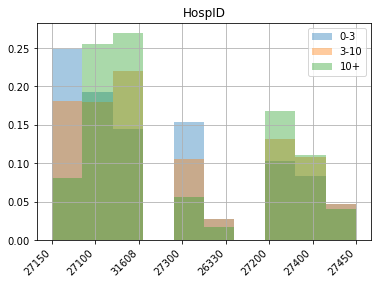

In [191]:
chunk_and_plot_categorical(demographics, 'HospID', {
    "alpha": 0.4
})

In [48]:
enumerate_categorical_variables(demographics, 'Payer_Type', 'Payer_Type_enum')

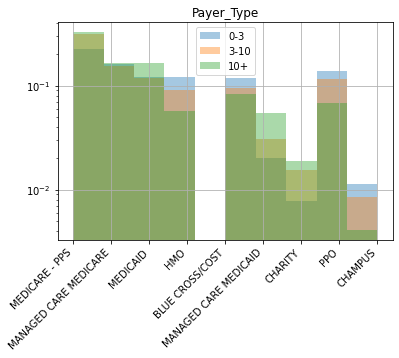

In [300]:
chunk_and_plot_categorical(demographics, 'Payer_Type', {
    "range": (0, 8),
    "alpha": 0.4,
    "log": True
})

In [50]:
enumerate_categorical_variables(demographics, 'Race1', 'race_enum')

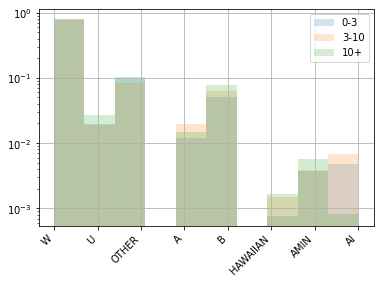

In [115]:
chunk_and_plot_categorical(demographics, 'Race1', {
    "alpha": 0.2,
    "log": True
})

In [106]:
query = """
select  me."Rel_Discharge_Day", md."OrigDX"
from ms_encounters me 
join ms_diagnosis md
on me."AdmtID" = md."AdmtID" 
where me."EncType" = 'I'
"""

dx = pd.read_sql_query(query, engine)

In [107]:
def mark_diagnosis(row, diagnosis):
    if row['OrigDX'] == diagnosis:
        return 'Has'
    else:
        return "Hasn't"


I10


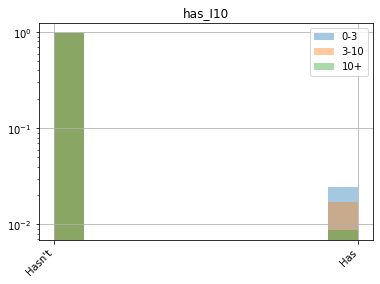

E78.5


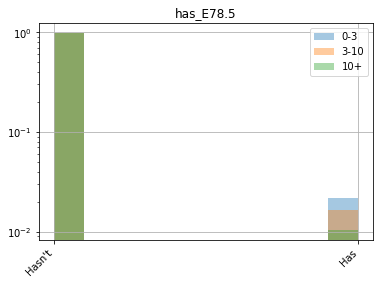

E11.9


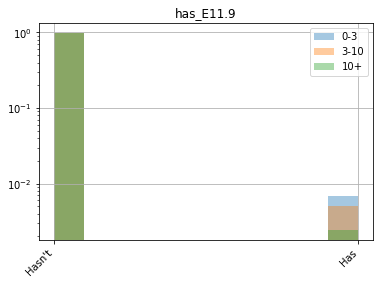

I25.10


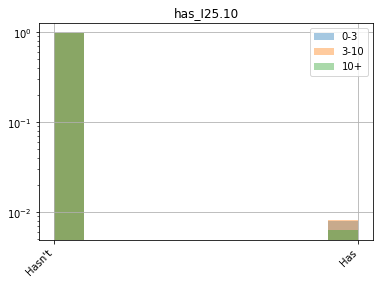

J44.9


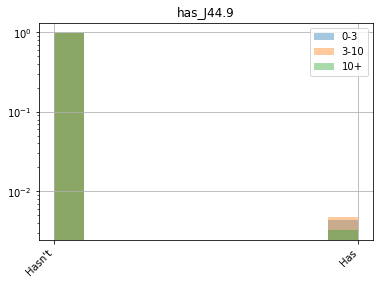

I12.9


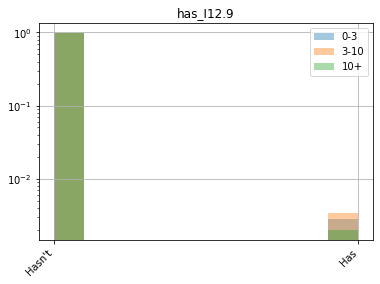

Y83.8


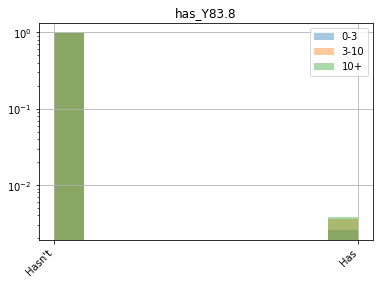

A41.9


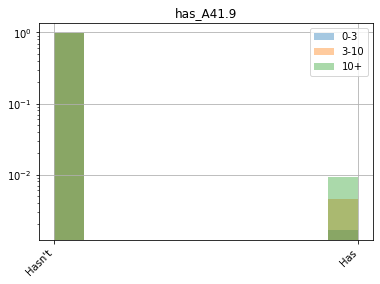

In [192]:
diagnoses = ['I10', 'E78.5', 'E11.9', 'I25.10', 'J44.9', 'I12.9', 'Y83.8', 'A41.9']

for diagnosis in diagnoses:
    label = f"has_{diagnosis}"
    dx[label] = dx.apply(lambda row: mark_diagnosis(row,  diagnosis), axis=1)
    chunk_and_plot_categorical(dx, label, {
        "alpha": 0.4,
        "log": True
    })
    plt.show()

In [155]:
query = """
select mv.*, me."Rel_Discharge_Day" from ms_vitals mv
left join ms_encounters me 
on mv."AdmtID" =me."AdmtID" 
where "Vital_Rel_Day" <= 0
and me."EncType" = 'I'
"""

vitals_at_admission = pd.read_sql_query(query, engine)

query = """
SELECT * FROM ms_encounters WHERE "EncType"='I'
"""

inpatient_encounters = pd.read_sql_query(query, engine)

def convert_to_datetime(row):
    return datetime.strptime('23:59:59', '%H:%M:%S') if row['Vital_Rpt_Time'] == '?' else datetime.strptime(row['Vital_Rpt_Time'], '%H:%M:%S')

vitals_at_admission['Vital_datetime'] = vitals_at_admission.apply(lambda row: convert_to_datetime(row), axis=1)

vitals_at_admission.sort_values(['Vital_Rel_Day', 'Vital_datetime'], inplace=True)

inpatient_admission_ids = inpatient_encounters['AdmtID']
vitals_for_inpatient_stays = vitals_at_admission[vitals_at_admission['AdmtID'].isin(inpatient_admission_ids)]
groupby_admissions = vitals_for_inpatient_stays.groupby('AdmtID')

In [172]:
vitals_dict = {}

def get_mean_of_continuous_variable(df, code, num_recent = 3):
    matched_code = df[df['Source_System_Original_Code'] == code]
    n_most_recent = matched_code.tail(num_recent)
    mean = n_most_recent['Vital_Result_Value_Txt'].astype(float).mean()
    return mean

def split_blood_pressure(blood_pressures):
    systolics = []
    diastolics = []
    for blood_pressure in blood_pressures:
        if blood_pressure is None:
            continue
        split = blood_pressure.split('/')
        systolics.append(int(split[0]))
        diastolics.append(int(split[1]))
    return (systolics, diastolics)

for name, group in groupby_admissions:
    blood_pressures = group[group['Vital_Id_Txt'] == 'Blood pressure:']['Vital_Result_Value_Txt'].reset_index(drop=True)

    systolic, diastolic = split_blood_pressure(blood_pressures)
    
    temperature_c = group[group['Source_System_Original_Code'] == 'K33010002A']['Vital_Result_Value_Txt'].reset_index(drop=True).astype(float)
    temperature_f = group[group['Source_System_Original_Code'] == 'K33010003A']['Vital_Result_Value_Txt'].reset_index(drop=True).astype(float)
    temperature_f_to_c = temperature_f.apply(lambda f: (f - 32) * (5/9))
    temperature_c.append(temperature_f_to_c)
    
    weight_kg = group[group['Source_System_Original_Code'] == 'K31010003A']['Vital_Result_Value_Txt'].reset_index(drop=True).astype(float)
    weight_lb = group[group['Source_System_Original_Code'] == 'K31010001A']['Vital_Result_Value_Txt'].reset_index(drop=True).astype(float)
    weight_lb_to_kg = weight_lb.apply(lambda lb: lb / 2.205)
    weight_kg.append(weight_lb_to_kg)
    
    
    vitals_dict[name] = {
        "mean_pulse": get_mean_of_continuous_variable(group, 'K33010006A'),
        "mean_oxygen_levels": get_mean_of_continuous_variable(group, 'L35010001A'),
        "mean_temperature_c": temperature_c.mean(),
        "mean_weight_kg": weight_kg.mean(),
        "systolic_blood_pressure": -1 if len(systolic) == 0 else statistics.mean(systolic[-3:]),
        "diastolic_blood_pressure": -1 if len(diastolic) == 0 else statistics.mean(diastolic[-3:]),
        "Rel_Discharge_Day": group['Rel_Discharge_Day'].shape[0]
    }

In [173]:
aggregated_vitals = pd.DataFrame(vitals_dict).T.reset_index().rename(index=int, columns={'index': 'AdmtID'})
aggregated_vitals.fillna(-1, inplace=True)

In [174]:
aggregated_vitals.head()

,AdmtID,mean_pulse,mean_oxygen_levels,mean_temperature_c,mean_weight_kg,systolic_blood_pressure,diastolic_blood_pressure,Rel_Discharge_Day
0,172480817323018509,68.000000,96.000000,36.421739,-1.00,116.333333,66.333333,104.0
1,181550818221412364,110.333333,96.666667,36.725000,29.30,105.000000,63.333333,51.0
2,181799000166943661,84.000000,93.000000,36.566667,96.25,136.333333,83.000000,27.0
3,181799000203983706,61.000000,94.666667,36.420000,-1.00,96.666667,65.000000,134.0
4,181799000215963959,-1.000000,-1.000000,36.000000,-1.00,-1.000000,-1.000000,5.0


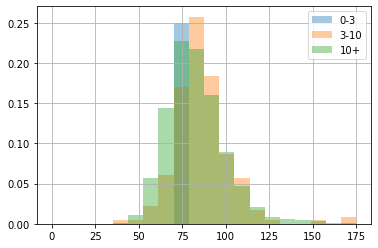

In [282]:
chunk_and_plot(aggregated_vitals, 'mean_pulse', {
    "bins": 20,
    "range": (0, 175),
    "alpha": 0.4
})

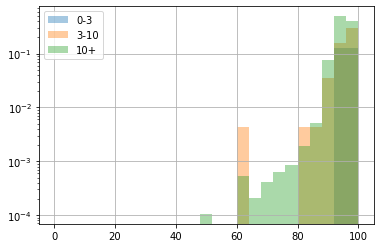

In [286]:
chunk_and_plot(aggregated_vitals, 'mean_oxygen_levels', {
    "bins": 25,
    "range": (0, 100),
    "alpha": 0.4,
    "log": True
})

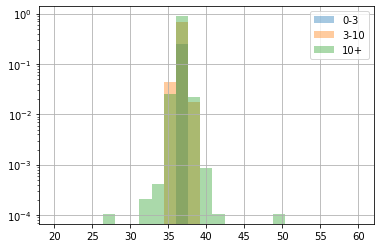

In [289]:
chunk_and_plot(aggregated_vitals, 'mean_temperature_c', {
    "bins": 25,
    "range": (20, 60),
    "alpha": 0.4,
    "log": True
})

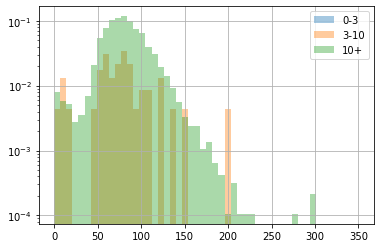

In [290]:
chunk_and_plot(aggregated_vitals, 'mean_weight_kg', {
    "bins": 50,
    "range": (0, 350),
    "alpha": 0.4,
    "log": True
})

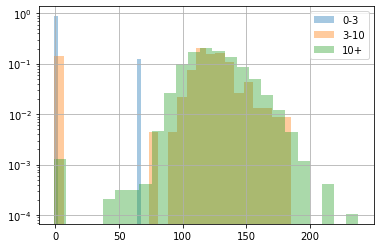

In [291]:
chunk_and_plot(aggregated_vitals, 'systolic_blood_pressure', {
    "bins": 25,
    "alpha": 0.4,
    "log": True
})

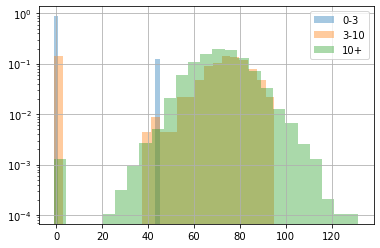

In [292]:
chunk_and_plot(aggregated_vitals, 'diastolic_blood_pressure', {
    "bins": 25,
    "alpha": 0.4,
    "log": True
})

In [194]:
def mark_procedure(row, procedure):
    if row['PX_Desc'] == procedure:
        return 'Received'
    else:
        return "Hasn't Received"

px_features = [
    "COMPLETE CBC AUTOMATED",
    "Fentanyl citrate injection",
    "TISSUE EXAM BY PATHOLOGIST",
    "Morphine sulfate injection",
    "Catheter, guiding",
    "TX/PRO/DX INJ NEW DRUG ADDON"
]   

In [224]:
query = """
select mp."PX_Desc", me."Rel_Discharge_Day"
from ms_procedures mp 
inner join ms_encounters me 
on mp."AdmtID" = me."AdmtID" 
where mp."Rel_Service_Day" <= 0
"""

procedures = pd.read_sql_query(query, engine)
px_df = procedures[["Rel_Discharge_Day"]]

Ondansetron hcl injection


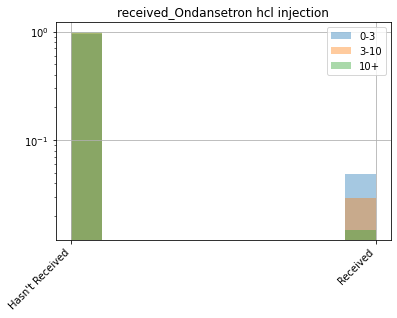

Inj, propofol, 10 mg


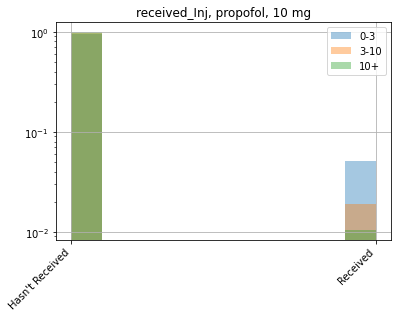

Ringers lactate infusion


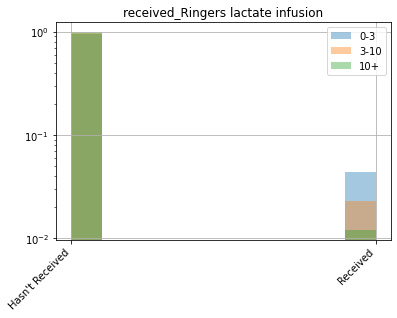

COMPLETE CBC AUTOMATED


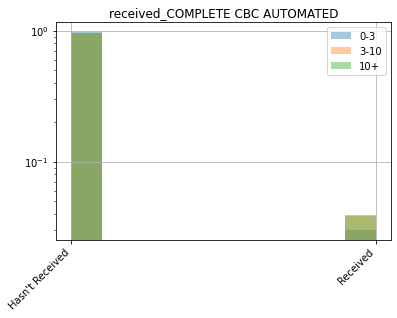

Normal saline solution infus


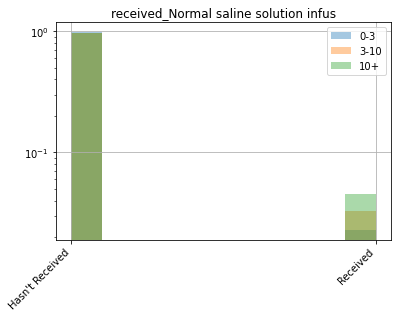

Compounded drug, noc


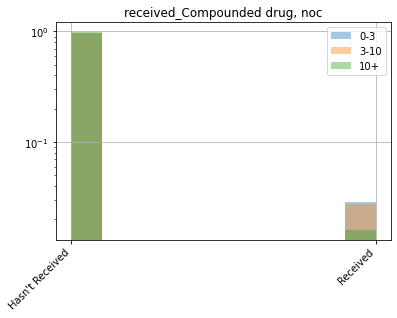

Dexamethasone sodium phos


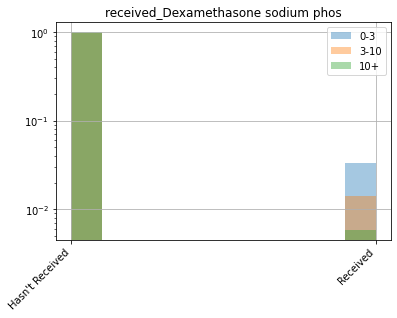

Inj midazolam hydrochloride


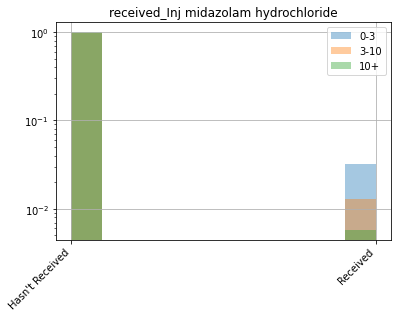

Cefazolin sodium injection


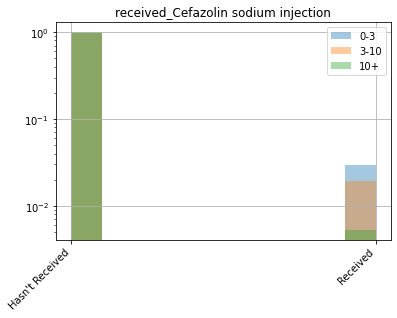

Anchor/screw bn/bn,tis/bn


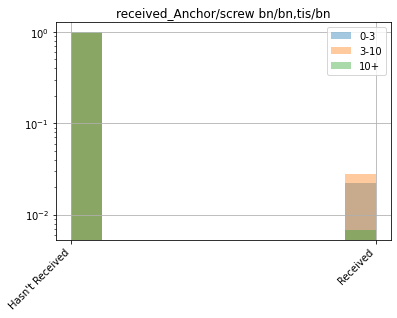

TISSUE EXAM BY PATHOLOGIST


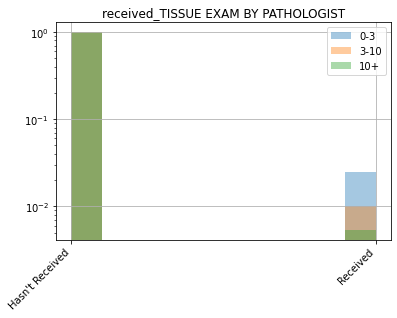

METABOLIC PANEL TOTAL CA


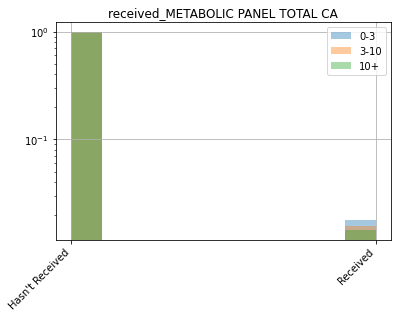

Joint device (implantable)


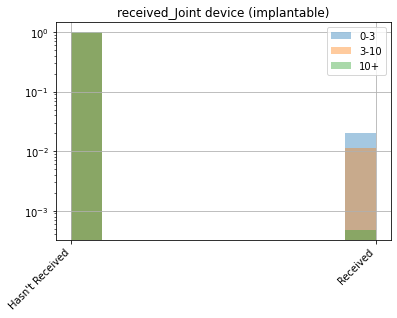

ELECTROCARDIOGRAM TRACING


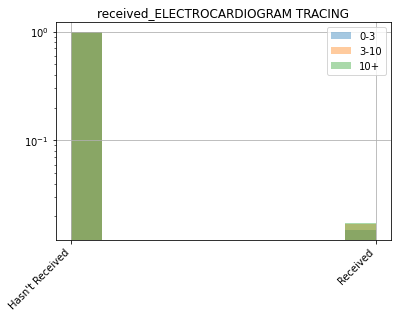

Ketorolac tromethamine inj


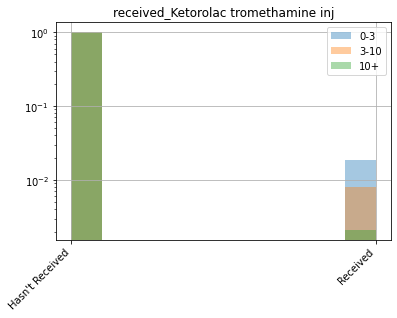

COMPREHEN METABOLIC PANEL


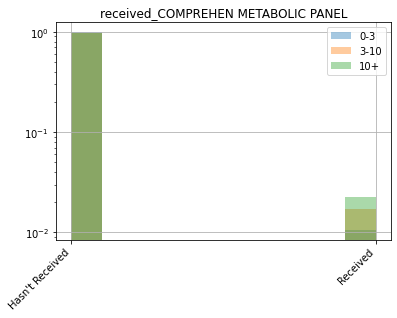

BLOOD TYPING SEROLOGIC RH(D)


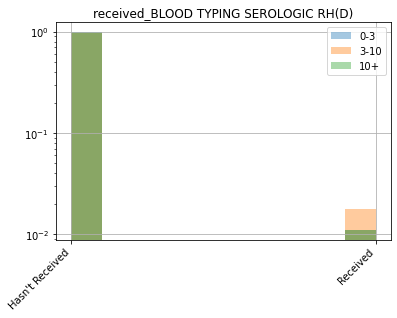

BLOOD TYPING SEROLOGIC ABO


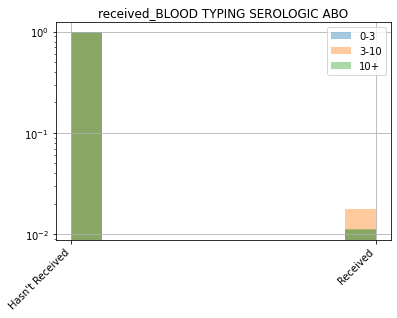

RBC ANTIBODY SCREEN


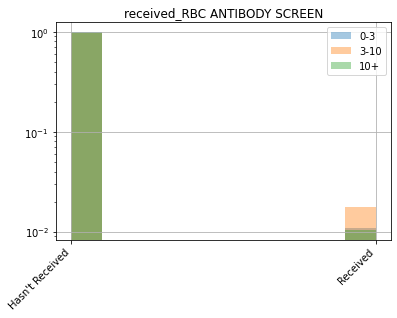

PROTHROMBIN TIME


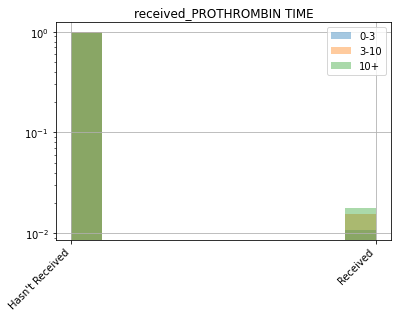

Inj heparin sodium per 1000u


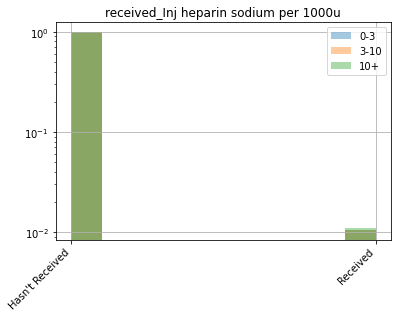

Guide wire


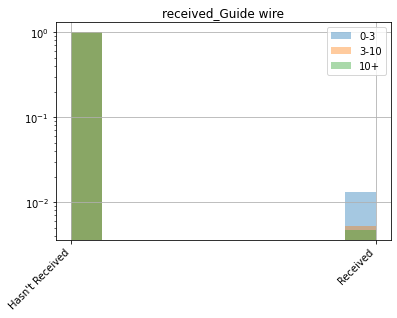

Fentanyl citrate injection


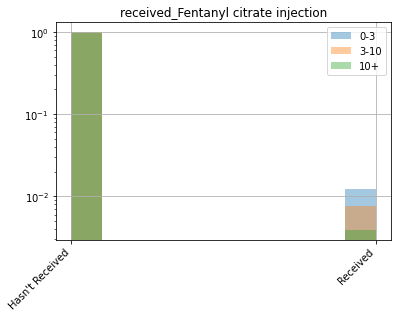

Neostigmine methylslfte inj


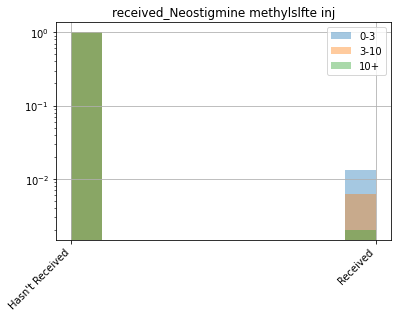

EMERGENCY DEPT VISIT


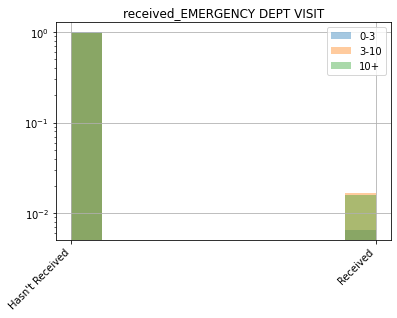

In [278]:
for px, i in procedures["PX_Desc"].value_counts()[:25].iteritems():
    label = f"received_{px}"
    px_df[label] = procedures.apply(lambda row: mark_procedure(row,  px), axis=1)
    print(px)
    chunk_and_plot_categorical(px_df, label, {
        "alpha": 0.4,
        "log": True
    })
    plt.show()

In [280]:
interesting_procedures = [
    "Ondansetron hcl injection",
    "Anchor/screw bn/bn,tis/bn",
    "Joint device (implantable)",
    "COMPREHEN METABOLIC PANEL",
    "Ketorolac tromethamine inj"
]

In [256]:
query = """
select *, me."Rel_Discharge_Day" 
from ms_inpatient_pharm mip 
inner join ms_encounters me 
on mip."AdmtID" = me."AdmtID" 
where mip."Rel_Admin_Date" <= 0
"""

meds = pd.read_sql_query(query, engine)

In [264]:
top_25_meds = drugs["Med"].value_counts()[:25]

DILAUDID


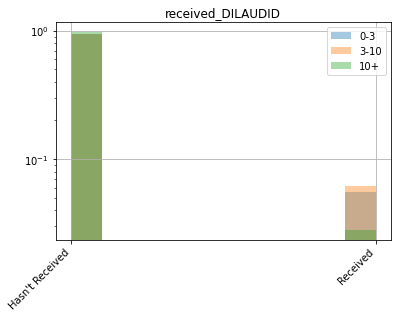

SUBLIMAZE


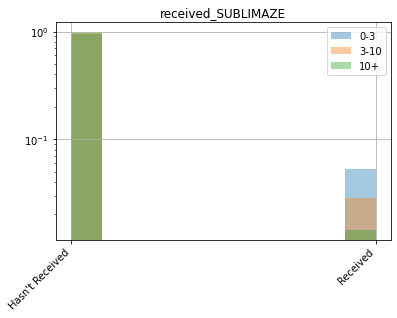

ZOFRAN


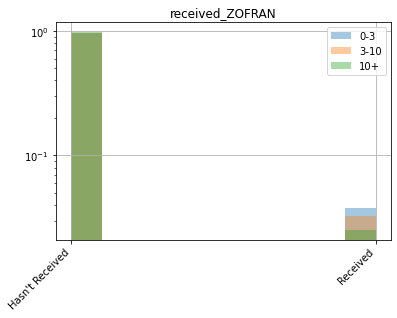

?


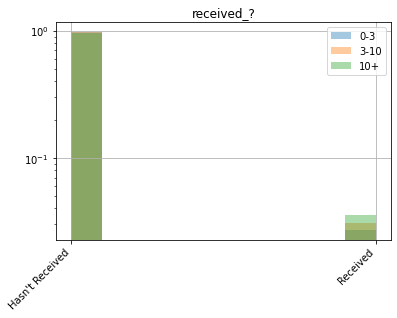

VERSED


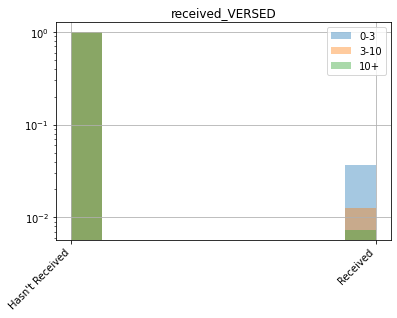

LACTATED RINGERS


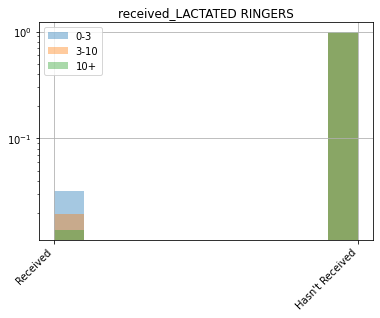

ROXICODONE


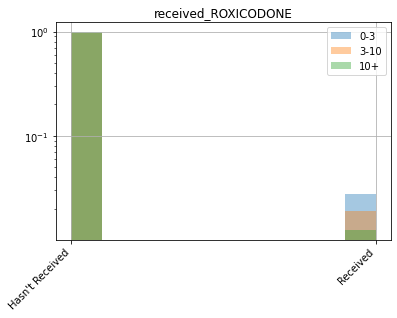

TylenoL


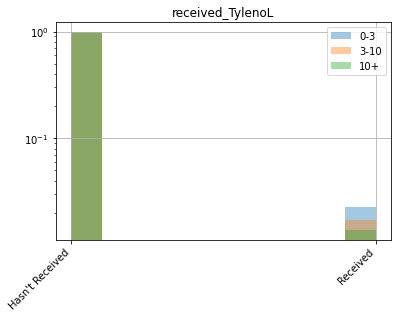

NACL-0.9%


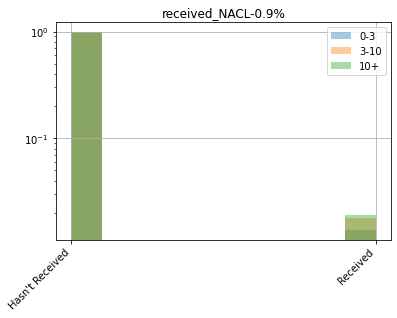

FENTANYL


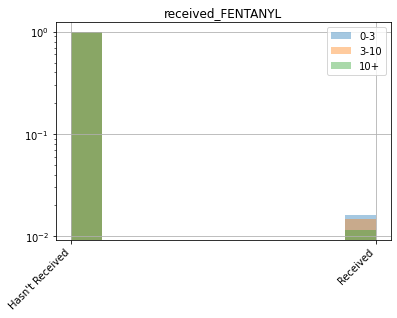

DILAUDID (iSECURE SYRINGE)


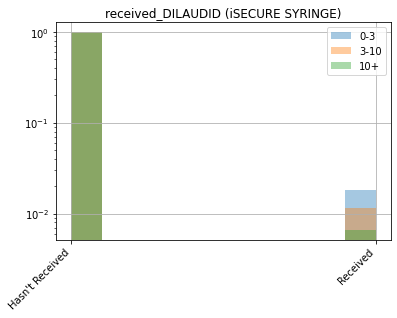

PEPCID


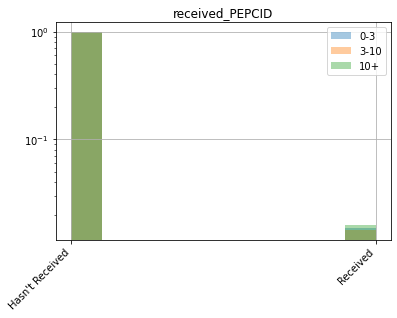

TORADOL


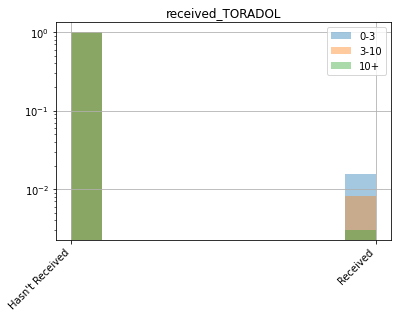

KEFZOL / ANCEF


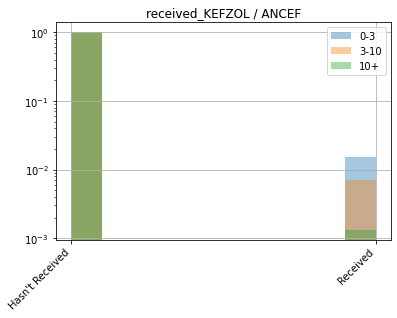

CeleBREX


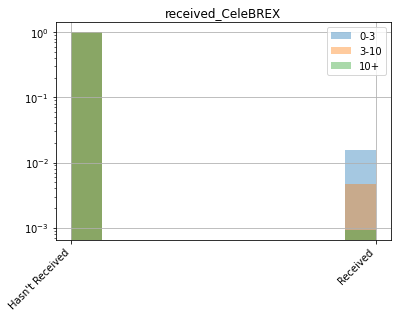

SODIUM CHLORIDE 0.9%


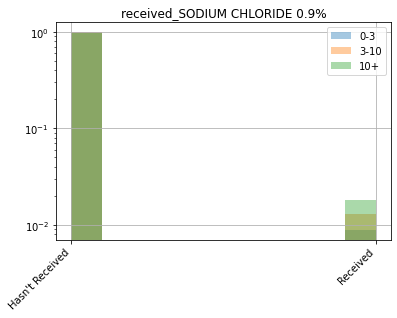

NEURONTIN


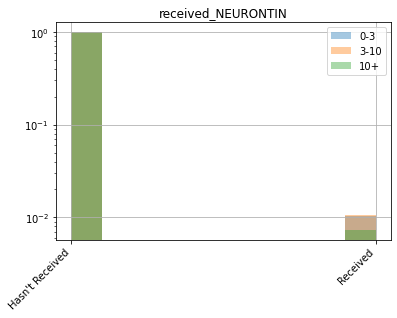

TYLENOL EXTRA STRENGTH


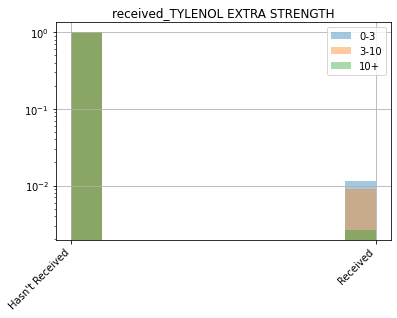

fentaNYL CITRATE


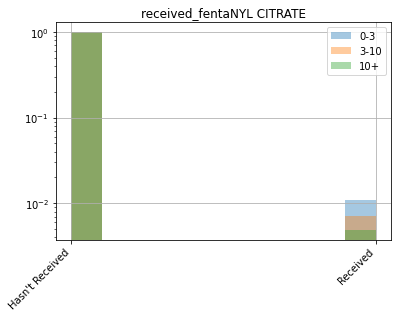

MORPHINE


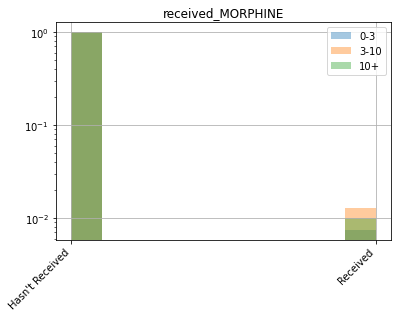

0.9 % SODIUM CHLORIDE


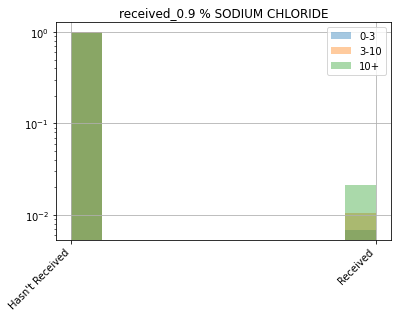

ULTRAM


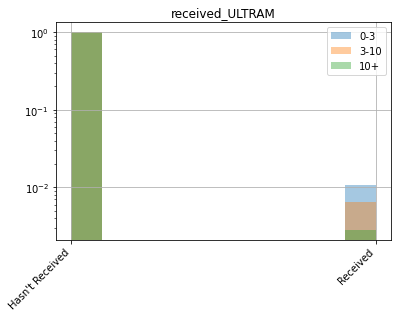

HEPARIN


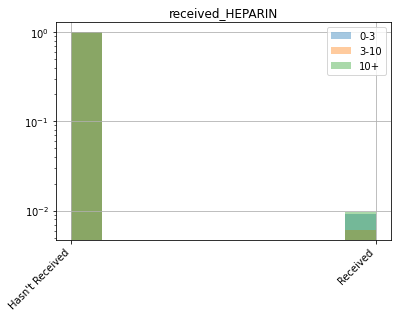

ANCEF


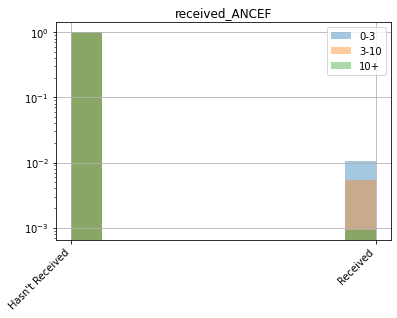

COLACE


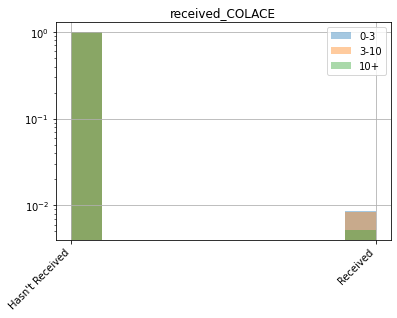

In [279]:
def mark_med(row, med):
    if row['Med'] == med:
        return 'Received'
    else:
        return "Hasn't Received"
    
meds_df = meds[["Rel_Discharge_Day"]]
meds_df = meds_df.loc[:,~meds_df.columns.duplicated()]

for med, i in top_25_meds.iteritems():
    label = f"received_{med}"
    meds_df[label] = meds.apply(lambda row: mark_med(row,  med), axis=1)
    print (med)
    chunk_and_plot_categorical(meds_df, label, {
        "alpha": 0.4,
        "log": True
    })
    plt.show()

In [ ]:
interesting_medications = [
    "SUBLIMAZE",
    "VERSED",
    "SODIUM CHLORIDE 0.9%",
    "0.9 % SODIUM CHLORIDE"
]